In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import torchvision
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Вы используете {device}")

Вы используете cuda


In [33]:
import warnings

# Отключите предупреждения
warnings.filterwarnings("ignore")

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"st3lfy","key":"02b52747087e4e64bb089003877be7cd"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 769M/778M [00:06<00:00, 112MB/s]
100% 778M/778M [00:06<00:00, 120MB/s]


In [ ]:
!unzip covid19-radiography-database.zip

In [7]:
root_folder_path = './COVID-19_Radiography_Dataset'

if os.path.isdir(root_folder_path):
    print("Исходная папка выбрана верно")
else:
    print("Такой папки нет")

Исходная папка выбрана верно


In [18]:
import shutil

folder_to_delete = './COVID-19_Radiography_Dataset'  # Указать путь к папке, которую нужно удалить

try:
    shutil.rmtree(folder_to_delete)  # Удалить папку и её содержимое
    print(f"Папка {folder_to_delete} успешно удалена.")
except Exception as e:
    print(f"Произошла ошибка при удалении папки {folder_to_delete}: {str(e)}")


Папка ./COVID-19_Radiography_Dataset успешно удалена.


In [8]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Укажите путь к папке с данными
data_dir = './COVID-19_Radiography_Dataset'

# Создайте папки для тренировочных и тестовых данных
train_dir = 'train_data'
test_dir = 'test_data'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Перечислите классы (папки) и их соответствующие пути
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Указываете размер тестового набора (в процентах)
test_size = 0.2

# Проходите по каждому классу и разделяйте данные на тренировочные и тестовые наборы
for class_name in classes:
    # Получите список файлов из папки images для текущего класса
    class_path = os.path.join(data_dir, class_name, 'images')
    files = os.listdir(class_path)

    # Разделите данные на тренировочные и тестовые наборы
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

    # Создайте папки для текущего класса в тренировочной и тестовой директориях
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Копируйте файлы в соответствующие папки
    for file in train_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(train_dir, class_name, file)
        shutil.copy(src, dst)

    for file in test_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(test_dir, class_name, file)
        shutil.copy(src, dst)

print("Данные разделены на тренировочный и тестовый наборы.")


Данные разделены на тренировочный и тестовый наборы.


In [9]:
import os

# Укажите путь к папкам с данными
train_dir = 'train_data'
test_dir = 'test_data'

# Перечислите классы (папки) и выводите размеры выборок
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

for class_name in classes:
    train_class_path = os.path.join(train_dir, class_name)
    test_class_path = os.path.join(test_dir, class_name)

    # Получите список файлов в каждой выборке
    train_files = os.listdir(train_class_path)
    test_files = os.listdir(test_class_path)

    # Выведите размеры выборок
    print(f'Класс: {class_name}')
    print(f'Размер тренировочной выборки: {len(train_files)} изображений')
    print(f'Размер тестовой выборки: {len(test_files)} изображений')
    print()


Класс: COVID
Размер тренировочной выборки: 2892 изображений
Размер тестовой выборки: 724 изображений

Класс: Lung_Opacity
Размер тренировочной выборки: 4809 изображений
Размер тестовой выборки: 1203 изображений

Класс: Normal
Размер тренировочной выборки: 8153 изображений
Размер тестовой выборки: 2039 изображений

Класс: Viral Pneumonia
Размер тренировочной выборки: 1076 изображений
Размер тестовой выборки: 269 изображений



In [10]:
import torch
from torchvision import datasets, transforms

# Определите пути к тренировочным и тестовым датасетам
train_data_path = 'train_data'
test_data_path = 'test_data'

# Определите преобразования для нормализации данных
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Создайте тренировочный и тестовый датасеты
train_dataset = datasets.ImageFolder(
    root=train_data_path,
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root=test_data_path,
    transform=transform
)

# Укажите размер пакета (batch size)
batch_size = 64

# Создайте тренировочный и тестовый даталоадеры
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f"Количество изображений в тренировочном датасете: {len(train_dataset)}")
print(f"Количество изображений в тестовом датасете: {len(test_dataset)}")


Количество изображений в тренировочном датасете: 16930
Количество изображений в тестовом датасете: 4235


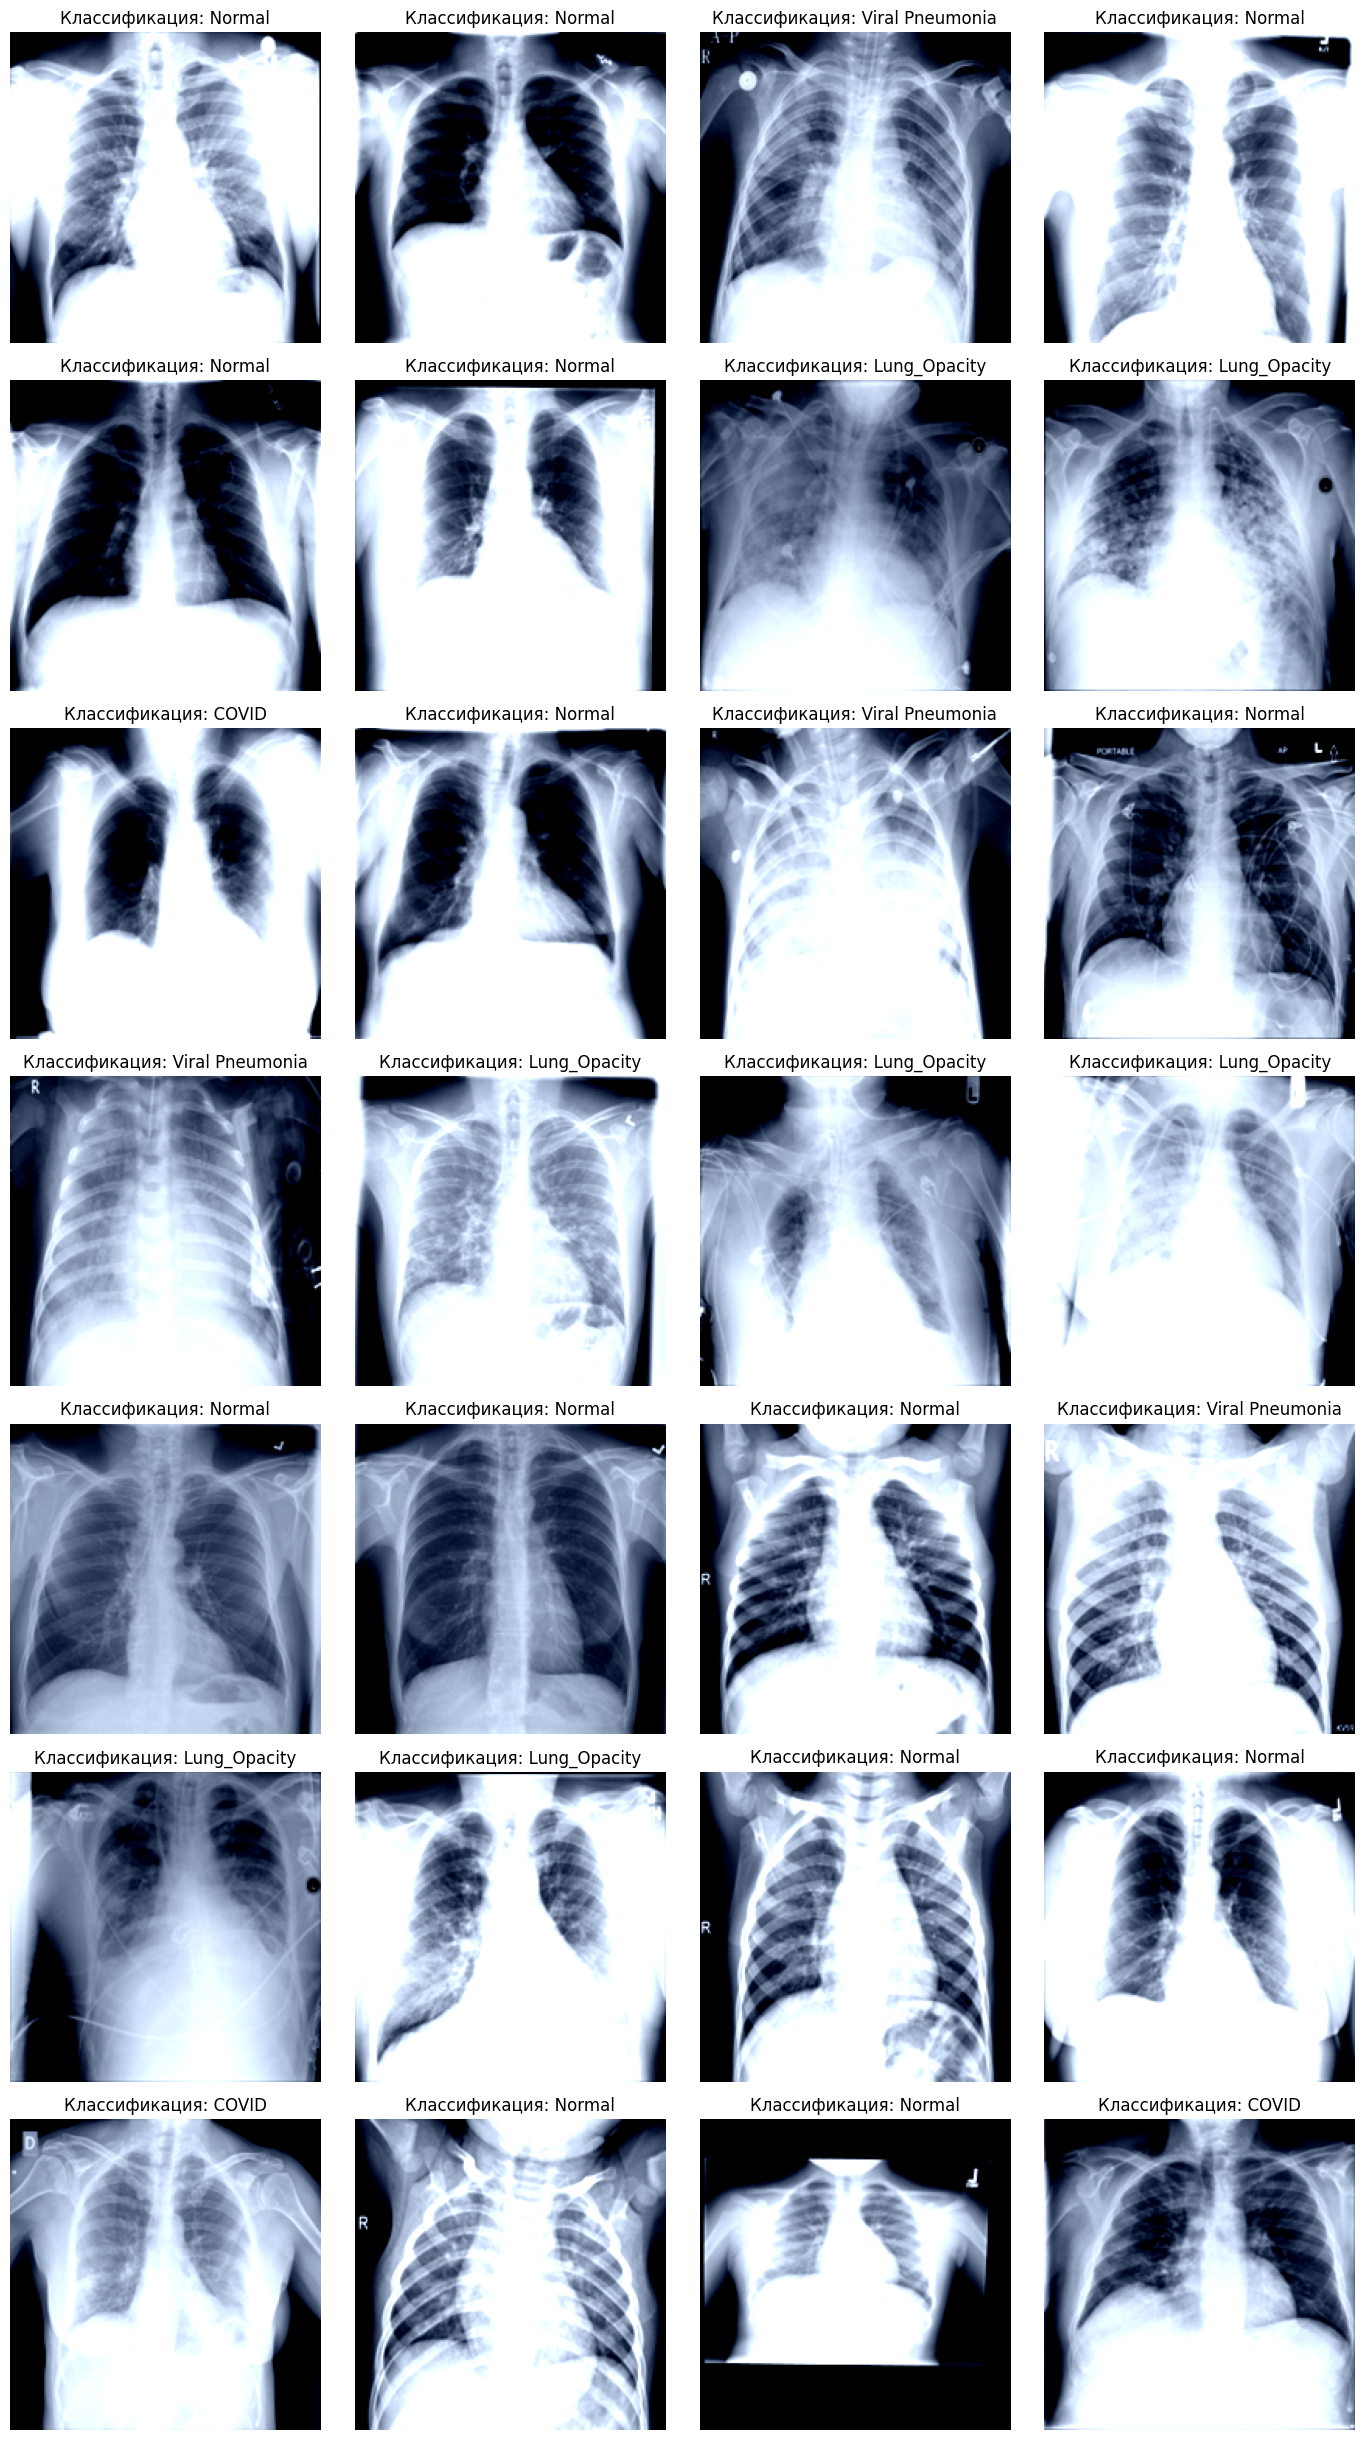

In [83]:
import numpy as np
import matplotlib.pyplot as plt

def show_images(dataset, num_rows=5, num_cols=5, image_size=(200, 200), dpi=100):
    class_indices = dataset.class_to_idx
    class_names = list(class_indices.keys())

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3.5, num_rows * 3.5), dpi=dpi)

    for i in range(num_rows):
        for j in range(num_cols):
            ax = axes[i, j]
            class_name = np.random.choice(class_names)
            class_index = class_indices[class_name]

            image_index = np.random.randint(len(dataset.targets))
            while dataset.targets[image_index] != class_index:
                image_index = np.random.randint(len(dataset.targets))

            image, label = dataset[image_index]

            image = np.clip(image.permute(1, 2, 0).numpy() * 0.5 + 0.5, 0, 1)

            ax.imshow(image)
            ax.set_title(f"Классификация: {class_name}")
            ax.axis('off')
            ax.set_frame_on(True)  # Добавить обводку

    plt.tight_layout()
    plt.show()

show_images(test_dataset, num_rows=7, num_cols=4)


In [21]:
# import torch.nn as nn

# class NN(nn.Module):
#     def __init__(self):
#         super(NN, self).__init__()
#         self.relu = nn.ReLU()
#         self.fc1 = nn.Linear(3 * 200 * 200, 2048)
#         self.fc2 = nn.Linear(2048, 1024)
#         self.fc3 = nn.Linear(1024, 512)
#         self.fc4 = nn.Linear(512, 128)
#         self.fc5 = nn.Linear(128, 16)
#         self.fc6 = nn.Linear(16, 4)

#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.fc3(x)
#         x = self.relu(x)
#         x = self.fc4(x)
#         x = self.relu(x)
#         x = self.fc5(x)
#         x = self.relu(x)
#         x = self.fc6(x)
#         return x

import torch.nn as nn

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(3 * 200 * 200, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

In [22]:
# Определите функцию потерь
criterion = nn.CrossEntropyLoss()

# Проверьте доступность GPU и выберите устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Переместите модель на выбранное устройство
model = NN().to(device)

# Определите оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Определите функцию обучения
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Переместите данные на GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        # Выводите промежуточные результаты
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader)} Accuracy: {accuracy}%')

# # Обучите модель
# num_epochs = 10
# train(model, train_loader, criterion, optimizer, num_epochs)

# # После обучения модели, вы можете оценить ее на тестовом датасете
# model.eval()
# correct = 0
# total = 0

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)  # Переместите данные на GPU
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# accuracy = 100 * correct / total
# print(f'Test Accuracy: {accuracy}%')

Epoch [1/10] Loss: 1.2793484068141794 Accuracy: 68.81275841701122%
Epoch [2/10] Loss: 0.6624697065578317 Accuracy: 75.62906083874779%
Epoch [3/10] Loss: 0.5705918975596158 Accuracy: 79.68694624926167%
Epoch [4/10] Loss: 0.4913306551159553 Accuracy: 81.6066154754873%
Epoch [5/10] Loss: 0.482608452214385 Accuracy: 81.93738924985233%
Epoch [6/10] Loss: 0.4585184957058925 Accuracy: 83.27820437093916%
Epoch [7/10] Loss: 0.43323660267973846 Accuracy: 84.06969875959835%
Epoch [8/10] Loss: 0.41429599934029127 Accuracy: 84.64264619019492%
Epoch [9/10] Loss: 0.4022197616550158 Accuracy: 84.69580626107502%
Epoch [10/10] Loss: 0.38349607260722035 Accuracy: 86.00118133490845%
Test Accuracy: 82.36127508854781%


In [90]:
# Загрузите предварительно обученную модель (например, ResNet)
pretrained_model = torchvision.models.resnet18(pretrained=True)

# Замените выходной слой для задачи классификации с 4 классами
num_classes = 4
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

# Переместите модель на GPU (если доступно)
pretrained_model = pretrained_model.to(device)

# Определите оптимизатор
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

# Обучите модель на вашем датасете
num_epochs = 50
train(pretrained_model, train_loader, criterion, optimizer, num_epochs)



Epoch [1/50] Loss: 0.30084542474656734 Accuracy: 89.35617247489664%
Epoch [2/50] Loss: 0.19530133077839634 Accuracy: 93.08919078558772%
Epoch [3/50] Loss: 0.15889115795352549 Accuracy: 94.38865918487892%
Epoch [4/50] Loss: 0.13861809073472922 Accuracy: 95.09746012994684%
Epoch [5/50] Loss: 0.11095889971222518 Accuracy: 96.11931482575311%
Epoch [6/50] Loss: 0.09682391484461303 Accuracy: 96.5150620200827%
Epoch [7/50] Loss: 0.07318425028813336 Accuracy: 97.22976963969285%
Epoch [8/50] Loss: 0.0659518580971602 Accuracy: 97.64914353219137%
Epoch [9/50] Loss: 0.05247863535417841 Accuracy: 98.14530419373892%
Epoch [10/50] Loss: 0.051981745282504356 Accuracy: 98.10395747194329%
Epoch [11/50] Loss: 0.0367682852773523 Accuracy: 98.60011813349084%
Epoch [12/50] Loss: 0.026476970996338663 Accuracy: 99.060838747785%
Epoch [13/50] Loss: 0.03855009604473862 Accuracy: 98.66509155345541%
Epoch [14/50] Loss: 0.031007357096773977 Accuracy: 98.84819846426461%
Epoch [15/50] Loss: 0.0300071231744094 Accura

In [101]:
# Оцените модель на тестовом датасете
pretrained_model.eval()
correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pretrained_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

correct = (np.array(predictions) == np.array(true_labels)).sum()
total = len(true_labels)
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy}%')

Test Accuracy: 92.34946871310508%


In [121]:
import torch

# Сохраните состояние модели
torch.save(pretrained_model.state_dict(), "pretrained_model.pth")


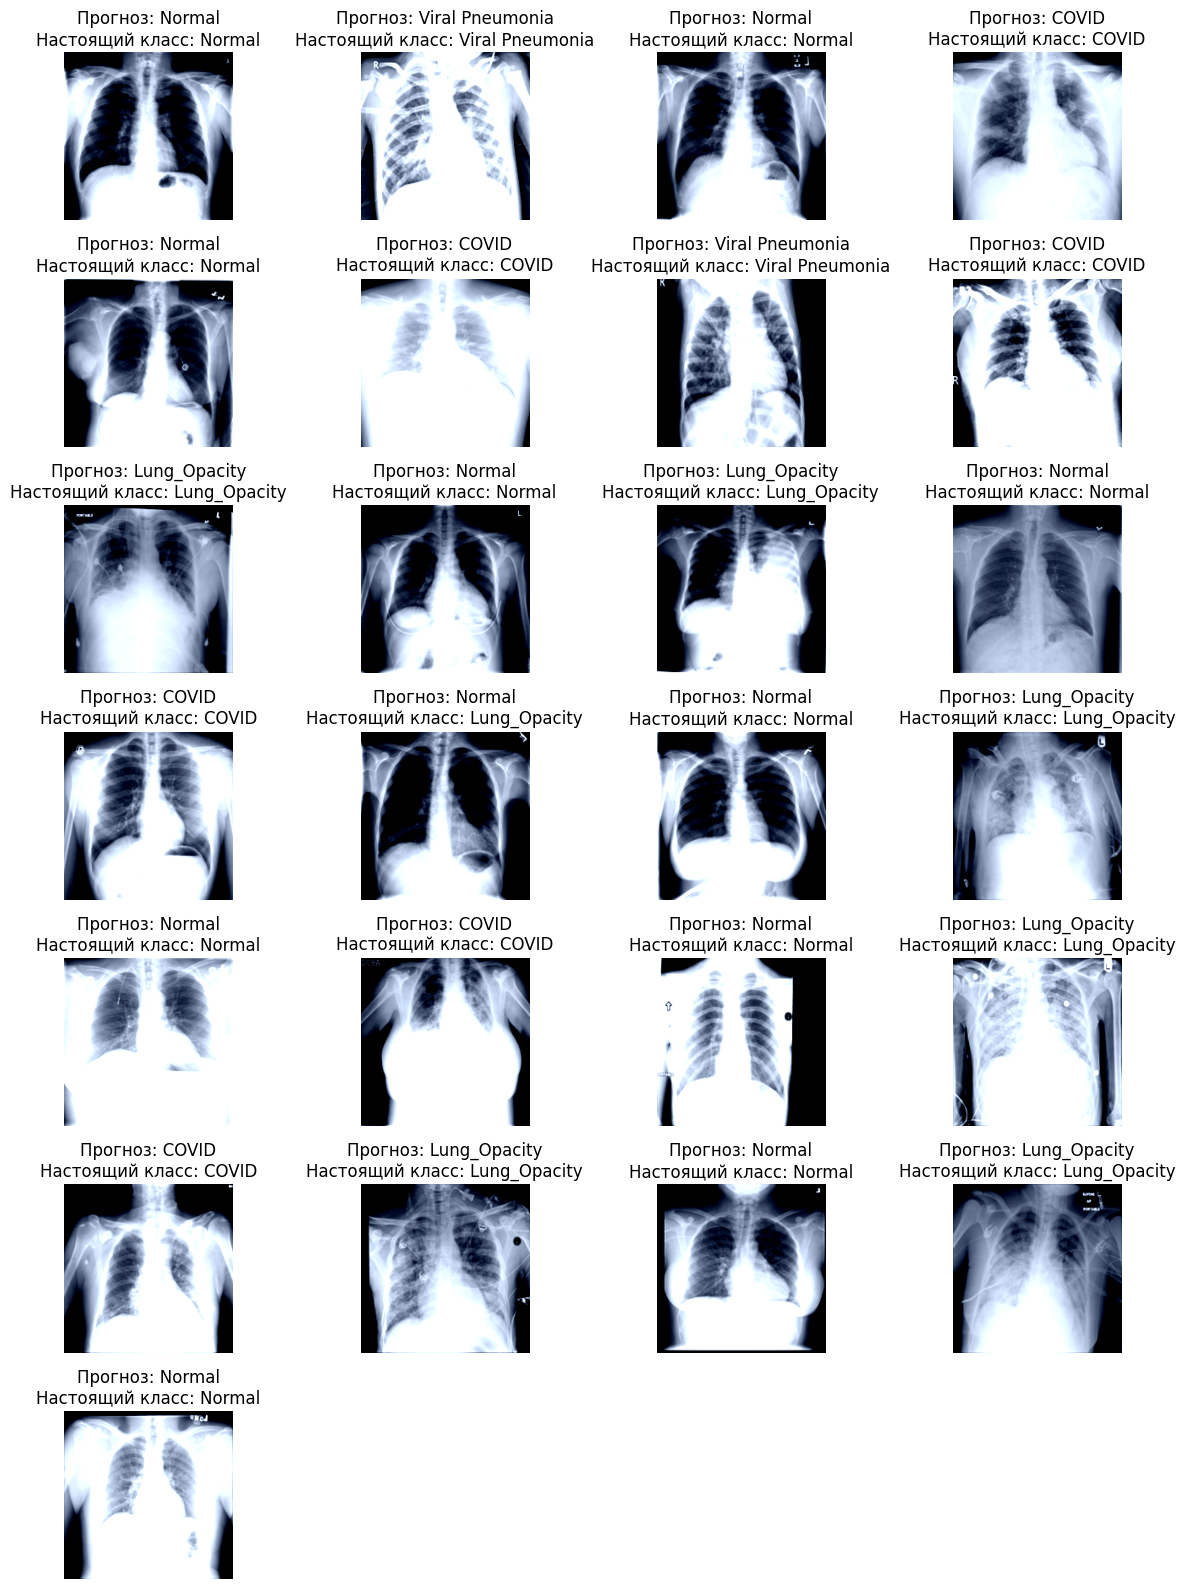

In [95]:
import random
import torch
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Функция для выбора случайного изображения из test_loader с условием разных классов
def select_random_image(test_loader, selected_images, num_images=25):
    dataset = test_loader.dataset
    while True:
        index = random.randint(0, len(dataset) - 1)
        images, labels = dataset[index]
        if len(selected_images) == 0 or labels != selected_images[-1][1]:
            selected_images.append((images, labels))
        if len(selected_images) == num_images:
            break

# Переведите модель в режим оценки (evaluation mode)
pretrained_model.eval()

# Выберите случайные 25 изображений из test_loader с разными классами
random.seed(45)
selected_images = []
select_random_image(test_loader, selected_images, num_images=25)

# Создайте пустую сетку для изображений
fig, axes = plt.subplots(7, 4, figsize=(12, 16))
axes = axes.ravel()

# Пройдите по выбранным изображениям и сделайте предсказания
with torch.no_grad():
    for i, (images, labels) in enumerate(selected_images):
        images = images.unsqueeze(0).to(device)  # Добавляем размерность батча

        outputs = pretrained_model(images)
        _, predicted = torch.max(outputs, 1)

        predicted_class = classes[predicted.item()]
        true_class = classes[labels]

        # Отобразите изображение без преобразования
        image = np.clip(images.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5, 0, 1)

        # Отобразите изображение на подходящем субграфике
        axes[i].imshow(image)
        axes[i].set_title(f"Прогноз: {predicted_class}\nНастоящий класс: {true_class}")
        axes[i].axis('off')

# Скройте пустые субграфики, если их количество меньше 28
for i in range(len(selected_images), 28):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


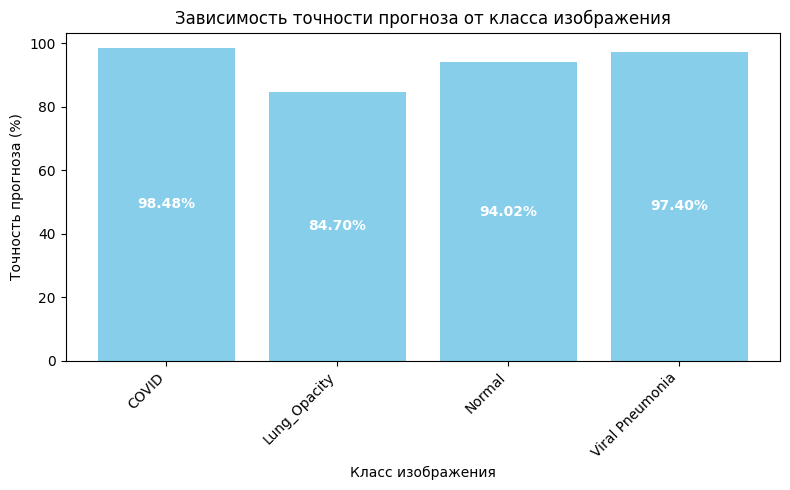

In [120]:
class_accuracy = {}
for class_name in classes:
    class_idx = classes.index(class_name)
    class_total = (np.array(true_labels) == class_idx).sum()
    class_correct = ((np.array(predictions) == class_idx) & (np.array(true_labels) == class_idx)).sum()
    class_accuracy[class_name] = 100 * class_correct / class_total

# Создайте фиксированный размер графика 500x500 пикселей
plt.figure(figsize=(8, 5), dpi=100)

# Создайте график
bars = plt.bar(classes, [class_accuracy[class_name] for class_name in classes], color='skyblue')
plt.ylabel('Точность прогноза (%)')  # Переместите проценты на вертикальную ось
plt.xlabel('Класс изображения')
plt.title('Зависимость точности прогноза от класса изображения')

# Поворачиваем подписи классов для лучшей читаемости
plt.xticks(rotation=45, ha='right')

# Добавляем аннотации с процентами и делаем текст белым цветом в центре каждого столбца
for bar, accuracy in zip(bars, [class_accuracy[class_name] for class_name in classes]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{accuracy:.2f}%', ha='center', va='center', color='white', weight=600)

plt.tight_layout()
plt.show()


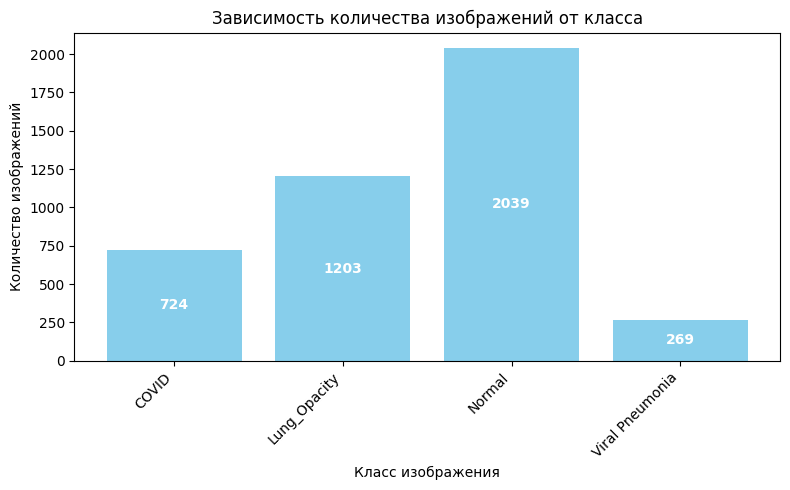

In [119]:
class_totals = {}
for class_name in classes:
    class_idx = classes.index(class_name)
    class_totals[class_name] = (np.array(true_labels) == class_idx).sum()

# Создайте фиксированный размер графика 500x500 пикселей
plt.figure(figsize=(8, 5), dpi=100)

# Создайте график
bars = plt.bar(classes, [class_totals[class_name] for class_name in classes], color='skyblue')
plt.ylabel('Количество изображений')  # Переместите количество изображений на вертикальную ось
plt.xlabel('Класс изображения')
plt.title('Зависимость количества изображений от класса')

# Поворачиваем подписи классов для лучшей читаемости
plt.xticks(rotation=45, ha='right')

# Добавляем аннотации с целыми числами в центре каждого столбца
for bar, total in zip(bars, [class_totals[class_name] for class_name in classes]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, str(total), ha='center', va='center', color='white', weight=600)

plt.tight_layout()
plt.show()
